# Understanding Audio Features through Sonification

1. Detect onsets in an audio signal. 
2. Segment the audio signal at each onset. 
3. Gain intuition into the features by listening to each segment separately. 
4. Extract Features of each segment, compute the zero crossing rate.
5. Scale each feature.
6. Using K-Means with defining the number of clusters beforehand. 
7. Affinity Propagation without defining the number of clusters beforehand. 

In [65]:
%matplotlib inline
import seaborn
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import sklearn, mir_eval, urllib


plt.rcParams['figure.figsize'] = (14, 4)
#plt.rcParams['figure.figsize'] = (13, 5)



## Step 1: Retrieve Audio

Load the audio file into an array.

In [66]:
x, sr = librosa.load('audio/simple_loop.wav')

Show the sample rate:

In [67]:
print (sr)

22050


Listen to the audio signal.

In [68]:
ipd.Audio(x, rate=sr)

Display the audio signal.

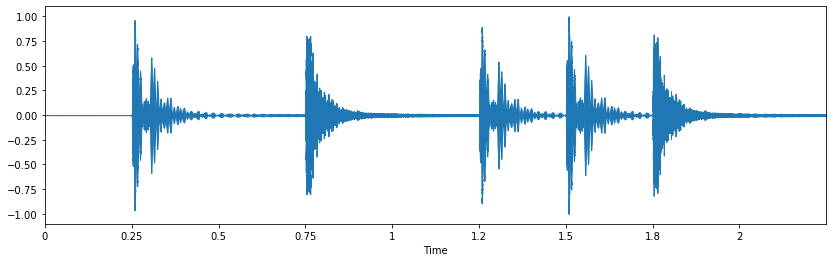

In [69]:
librosa.display.waveplot(x, sr=sr)

Compute the short-time Fourier transform:

In [70]:
X = librosa.stft(x)

For display purposes, compute the log amplitude of the STFT:

In [71]:
#Xmag = librosa.logamplitude(X)
Xmag = librosa.amplitude_to_db(X)


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:1029: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


Display the spectrogram.

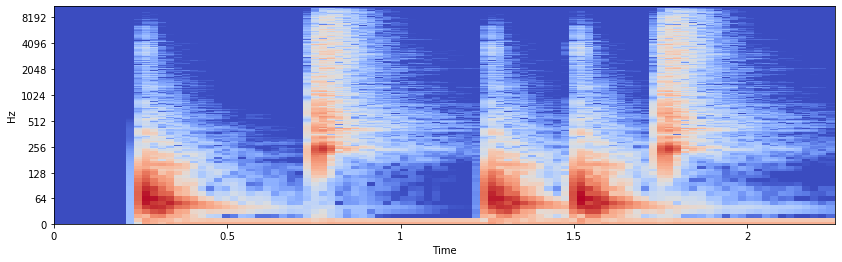

In [72]:
# Play with the parameters, including x_axis and y_axis
librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log')

## Step 2: Detect Onsets

Find the times, in seconds, when onsets occur in the audio signal.

In [73]:
onset_frames = librosa.onset.onset_detect(x, sr=sr)
print (onset_frames)

[12 33 55 66 76]


In [74]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
print (onset_times)

[0.27863946 0.7662585  1.27709751 1.53251701 1.76471655]


Convert the onset frames into sample indices.

In [75]:
onset_samples = librosa.frames_to_samples(onset_frames)
print (onset_samples)

[ 6144 16896 28160 33792 38912]


Play a "beep" at each onset.

In [76]:
# Use the `length` parameter so the click track is the same length as the original signal
clicks = librosa.clicks(times=onset_times, length=len(x))
#print(clicks)

In [77]:
# Play the click track "added to" the original signal
ipd.Audio(x+clicks, rate=sr)

## Step 3: Segment the Audio

Save into an array, `segments`, 100-ms segments beginning at each onset.

In [78]:
frame_sz = int(0.100*sr)
segments = numpy.array([x[i:i+frame_sz] for i in onset_samples])

Here is a function that adds 300 ms of silence onto the end of each segment and concatenates them into one signal.

Later, we will use this function to listen to each segment, perhaps sorted in a different order.

In [79]:
def concatenate_segments(segments, sr=22050, pad_time=0.300):
    padded_segments = [numpy.concatenate([segment, numpy.zeros(int(pad_time*sr))]) for segment in segments]
    return numpy.concatenate(padded_segments)

In [80]:
concatenated_signal = concatenate_segments(segments, sr)

Listen to the newly concatenated signal.

In [81]:
ipd.Audio(concatenated_signal, rate=sr)

## Step 4: Extract Features

For each segment, compute the zero crossing rate.

In [82]:
zcrs = [sum(librosa.core.zero_crossings(segment)) for segment in segments]
print (zcrs)

[11, 570, 11, 10, 568]


Use `argsort` to find an index array, `ind`, such that `segments[ind]` is sorted by zero crossing rate.

In [83]:
ind = numpy.argsort(zcrs)
print (ind)

[3 0 2 4 1]


Sort the segments by zero crossing rate, and concatenate the sorted segments.

In [84]:
concatenated_signal = concatenate_segments(segments[ind], sr)

Compute the zero crossing rate and energy for each detected onset.

Plot the zero crossing rate:

In [85]:
def extract_features(x, sr):
    zcr = librosa.zero_crossings(x).sum()
    energy = scipy.linalg.norm(x)
    return [zcr, energy]


In [86]:
frame_sz = sr*0.090
features = numpy.array([extract_features( x[i:int(i+frame_sz)], sr) for i in onset_samples])
print (features.shape)

(5, 2)


## Step 5: Feature Scaling

Scale the features (using the scale function) from -1 to 1.

In [87]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
print (features_scaled.shape)
print (features_scaled.min(axis=0))
print (features_scaled.max(axis=0))

(5, 2)
[-1. -1.]
[1. 1.]


# Step 6:  Using K-Means

Sometimes, an unsupervised learning technique is preferred. Perhaps you do not have access to adequate training data, or perhaps the training data's labels are not completely clear. Maybe you just want to quickly sort real-world, unseen, data into groups based on its feature similarity.

In such cases, clustering is a great option! 

Let's initialize the algorithm to find three clusters.

In [88]:
model = sklearn.cluster.KMeans(n_clusters=2)
labels = model.fit_predict(features_scaled)
print (labels)

[0 1 0 0 1]


Plot the results.

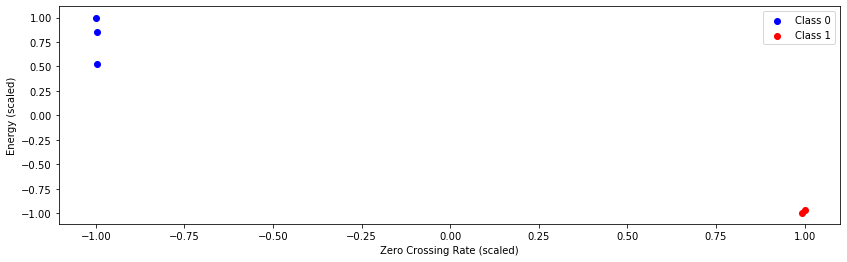

In [89]:
plt.scatter(features_scaled[labels==0,0], features_scaled[labels==0,1], c='b')
plt.scatter(features_scaled[labels==1,0], features_scaled[labels==1,1], c='r')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1'))

Listen to onsets assigned to Class 0:

In [90]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==0], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

Class 1:

In [91]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==1], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

# Step 7: Affinity Propagation

In scikit-learn, other clustering algorithms such as affinity propagation can cluster without defining the number of clusters beforehand.

All we need to do is swap out KMeans for AffinityPropagation:

In [92]:
model = sklearn.cluster.AffinityPropagation()
labels = model.fit_predict(features_scaled)
print (labels)

[0 1 0 0 1]


Plot features:

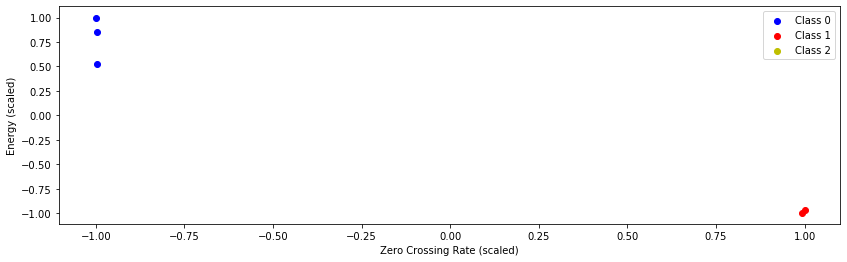

In [93]:
plt.scatter(features_scaled[labels==0,0], features_scaled[labels==0,1], c='b')
plt.scatter(features_scaled[labels==1,0], features_scaled[labels==1,1], c='r')
plt.scatter(features_scaled[labels==2,0], features_scaled[labels==2,1], c='y')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1', 'Class 2'))

### Play a beep upon each frame in the same cluster:

Class 0:

In [94]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==0], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

Class 1:

In [95]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==1], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

Class 2:

In [96]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==2], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)